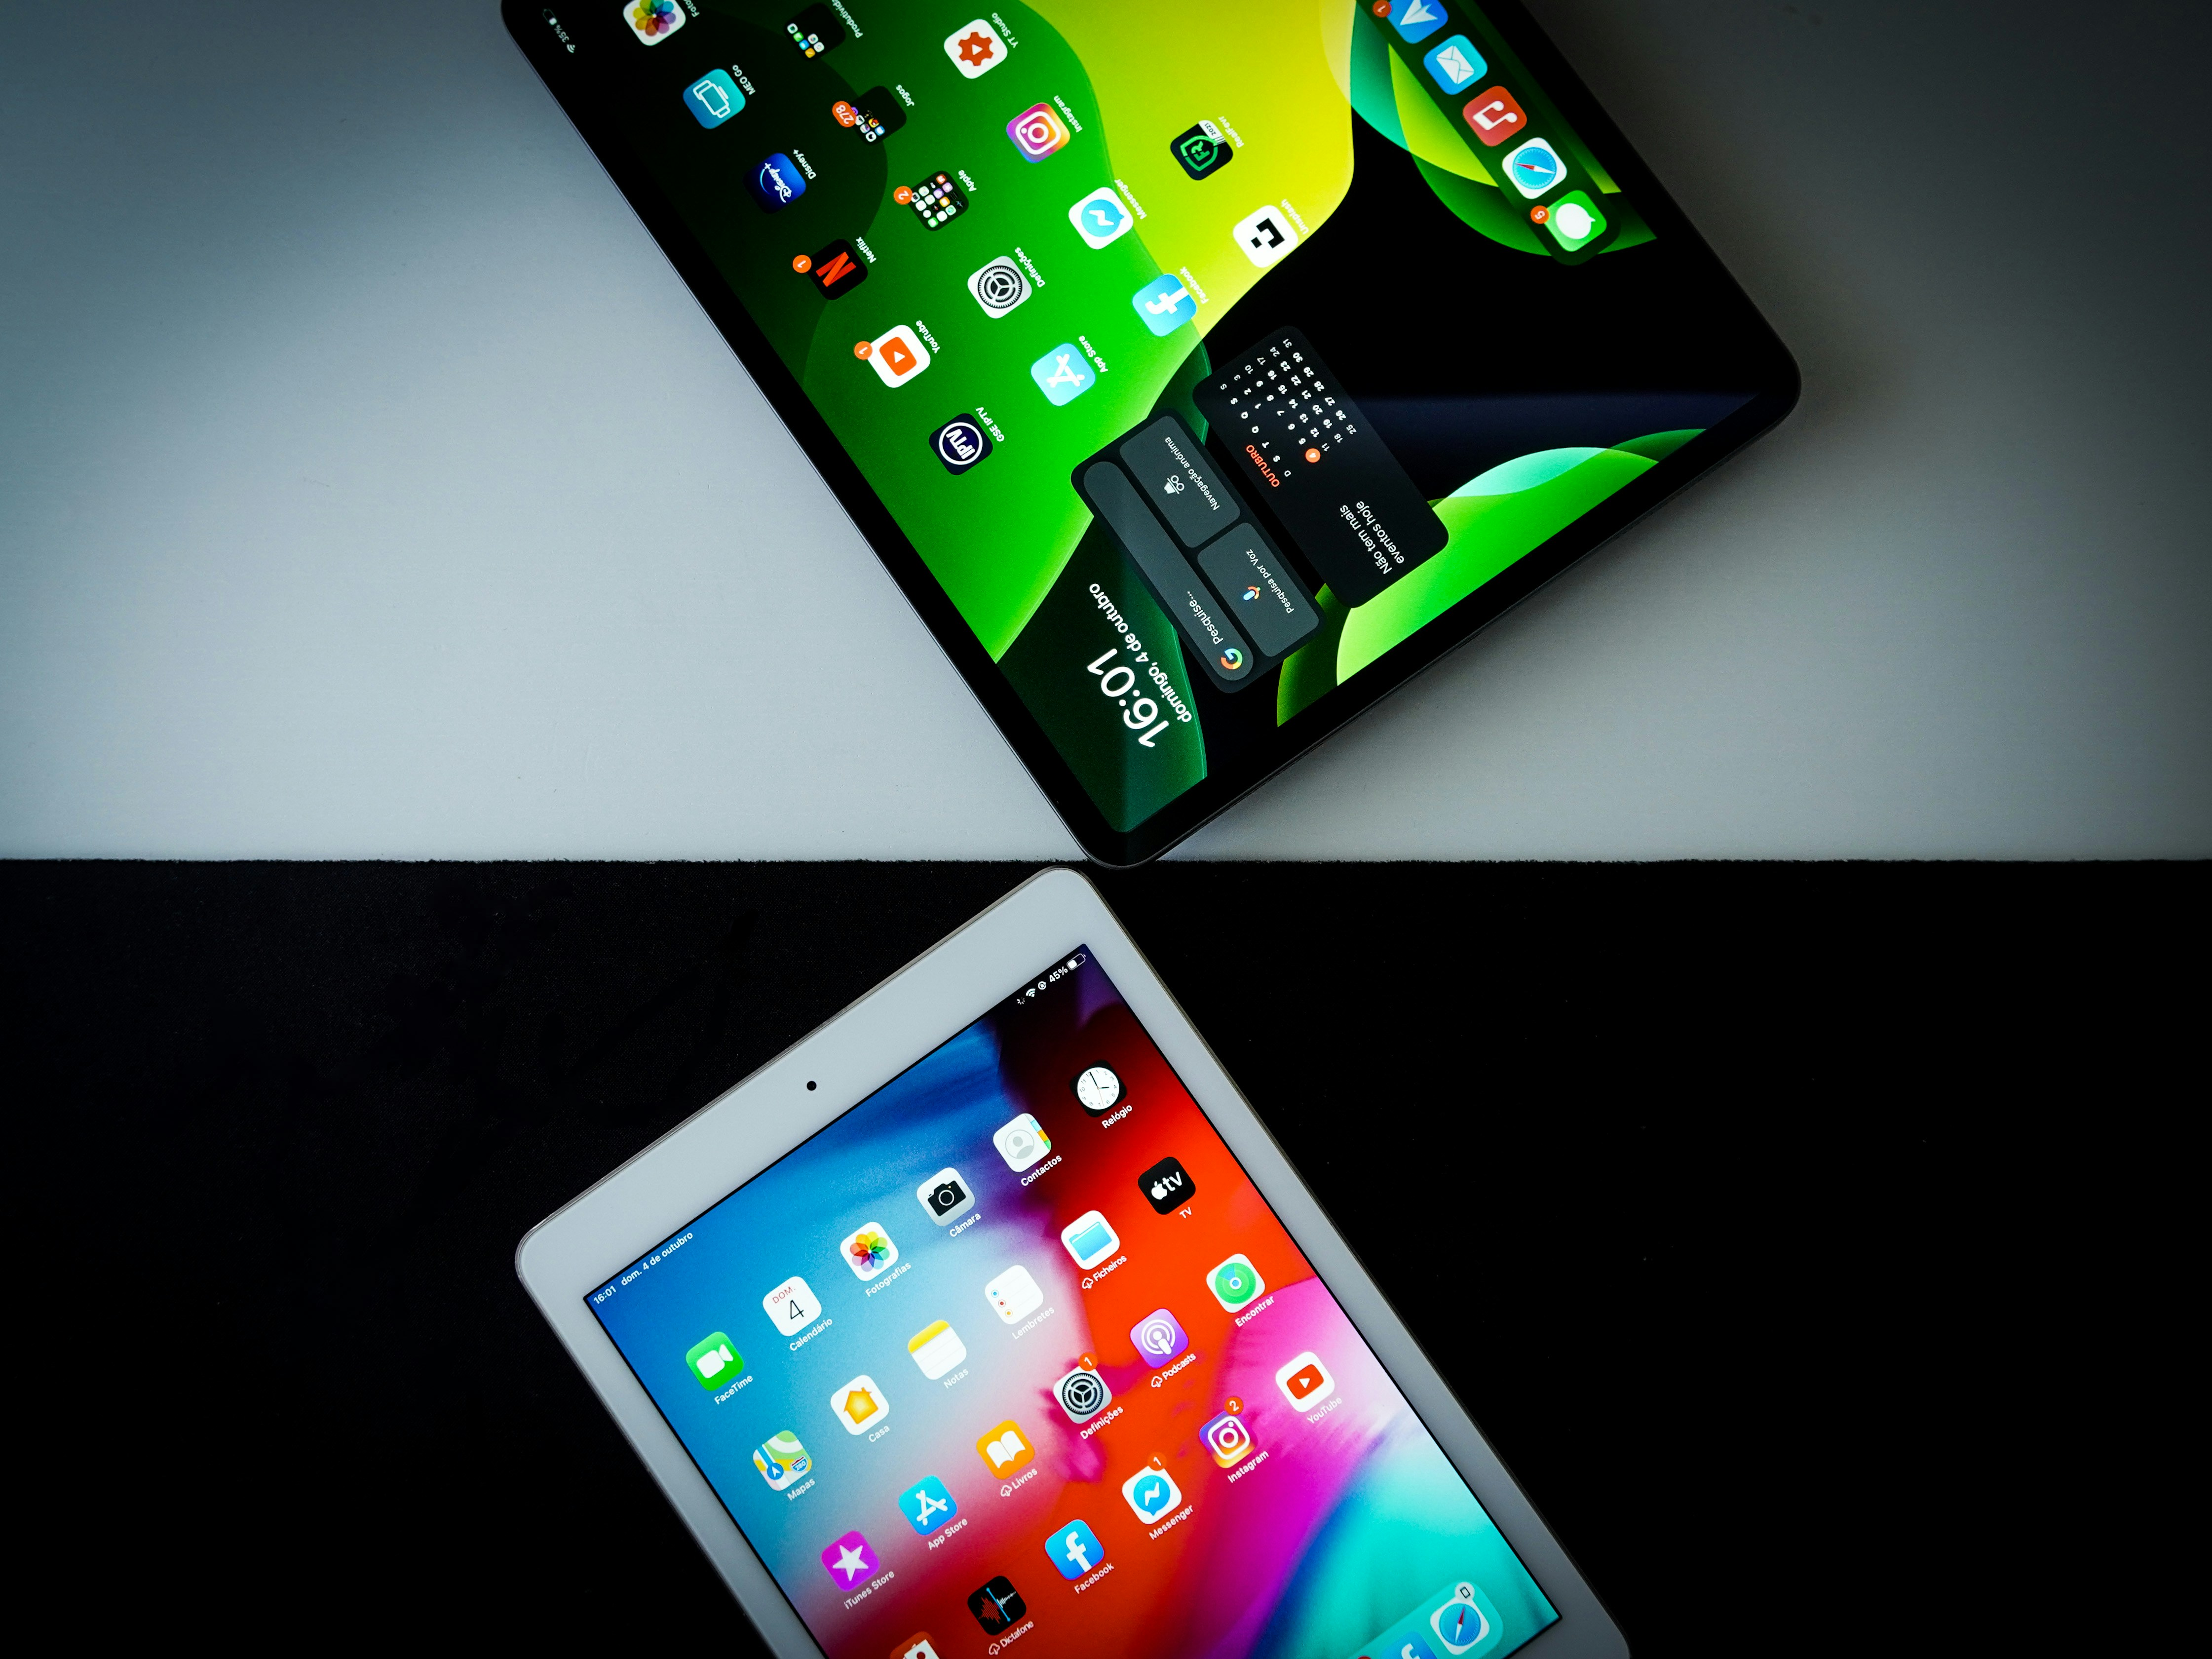

# Apple Sentiment Analysis at the SXSW 2013 Conference
#### By Sarah Prusaitis, Rick Lataille, and Allison Ward
 

## Project Overview 
This project analyzes the overall sentiment towards Apple products at the SXSW conference in 2013 through the tweets of conference attendees. The SXSW conference is a yearly event in Austin, Texas that revolves around technology, education, music, culture, and politics. The goal is to understand how the public perceives Apple products during this high-profile event and to identify trends or patterns in sentiment. This information will help make data-driven decisions for future product launches and marketing campaigns.

## Data Overview
Data was provided from CrowdFlower and downloaded from data.world. Tweets were labeled as positive, negative, neutral, or uncertain in emotion by human raters.

Before beginning the modeling process, class imbalance needed to be addressed, as positive tweets accounted for significantly more tweets than those with negative sentiment. To balance the data, chatGPT was used to synthetically create 1,477 negative tweets, ensuring they followed the formatting of the original dataset and were relevant to the 2013 SXSW conference. ChatGPT was prompted with example negative tweets to ensure the synthetic ones were comparable in content to the original tweets.

# Analysis

In [1]:
#importing packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

import re
import string
import time
import langid

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
# read original data
df1 = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = 'ISO-8859-1')

In [3]:
# read synthetic data
df2 = pd.read_csv('data/Apple_Product_Negative_ Tweets_Sheet1.csv', encoding = 'ISO-8859-1')

In [4]:
# rename columns for simplicity
df1 = df1.rename(columns = {'tweet_text': 'tweet', 
                         'emotion_in_tweet_is_directed_at': 'product', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})

In [5]:
#combine data sets into a single dataframe
df = pd.concat([df1, df2], ignore_index = True)

In [6]:
df.shape

(10569, 3)

In [7]:
df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [8]:
df.tail()

,tweet,product,sentiment
10564,Why do I feel like Apple's product updates are...,Apple,Negative emotion
10565,Apple's latest feature: making you wish you ha...,Apple,Negative emotion
10566,"Just when you thought your device was perfect,...",Apple,Negative emotion
10567,Apple's latest innovation is convincing us we ...,Apple,Negative emotion
10568,Each new Apple release is an exercise in disco...,Apple,Negative emotion


In [9]:
type_count = df['tweet'].apply(type).value_counts()

print(type_count)

tweet
<class 'str'>      10568
<class 'float'>        1
Name: count, dtype: int64


In [10]:
df['product'].value_counts()

product
Apple                              2137
iPad                                946
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: count, dtype: int64

In [11]:
df['sentiment'].value_counts()

sentiment
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                      2046
I can't tell                           156
Name: count, dtype: int64

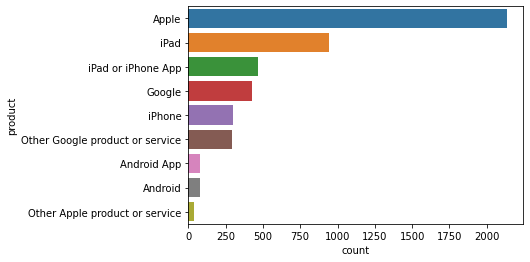

In [12]:
x = df['product'].value_counts()
y = x.index
sns.barplot(x=x, y=y);

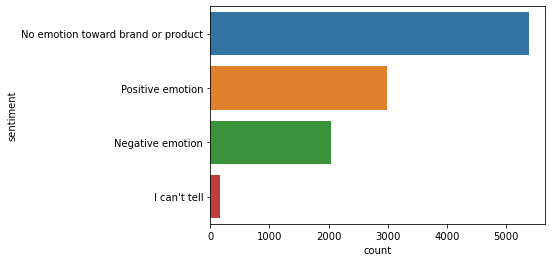

In [13]:
x = df['sentiment'].value_counts()
y = x.index
sns.barplot(x=x, y=y);

# Preprocessing

In [14]:
# Combined and renamed Apple products and non Apple products 

df['product'] = df['product'].replace({
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Other',
    'Other Google product or service': 'Other',
    'Android App': 'Other',
    'Android': 'Other'
})

In [15]:
# Filter DataFrame for only Apple tweets, and drop 'product column'
df_apple = df[df['product']=='Apple'].drop('product',axis=1).copy()

In [16]:
# Consolidate no emotion entries, and drop
df_apple['sentiment'] = df_apple['sentiment'].replace("I can't tell", "No emotion toward brand or product")
df_apple = df_apple.drop(df_apple[df_apple['sentiment'] == 'No emotion toward brand or product'].index).reset_index(drop=True)

In [17]:
df_apple['tweet'] = df_apple['tweet'].astype(str)

In [18]:
def replace_emoticons(text):
    # Define a dictionary mapping emoticons to their corresponding meanings
    emoticon_mapping = {
        ':D': 'emojismile',
        ':)': 'emojismile',
        ':-D': 'emojismile',
        ':\'': 'emojiunsure',
        ':p': 'emojitongue',
        ':P': 'emojitongue',
        ':(': 'emojisad'
        # Add more emoticons and their meanings as needed
    }
    pattern = re.compile('|'.join(re.escape(emoticon) for emoticon in emoticon_mapping.keys()))
    def replace(match):
        return emoticon_mapping[match.group(0)]

    return pattern.sub(replace, text)


In [19]:
# Replace emoticons with mapped strings
df_apple['tweet'] = df_apple['tweet'].apply(replace_emoticons)

In [20]:
def preprocess_tweet(tweet):
    # Remove links and mentions
    tweet = re.sub(r'http\S+|@\S+', '', tweet)
    
    # Remove {link}
    tweet = re.sub(r'\{link\}', '', tweet)
    
    # Replace &quot; with "
    tweet = tweet.replace('&quot;', '"')
    
    # Remove extra space between quotation mark and words
    tweet = re.sub(r'\s+"', '"', tweet)
    tweet = re.sub(r'"\s+', '"', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    
    # Remove punctuation
    tweet = re.sub(r'([^\w\s]|_)+', ' ', tweet)
    
    # Tokenize
    tokens = nltk.word_tokenize(tweet)
    
    # Part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for word, pos in tagged_tokens:
        if pos.startswith('J'):
            pos = 'a'  # Adjective
        elif pos.startswith('V'):
            pos = 'v'  # Verb
        elif pos.startswith('N'):
            pos = 'n'  # Noun
        elif pos.startswith('R'):
            pos = 'r'  # Adverb
        else:
            pos = 'n'  # Default to noun
        lemma = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_tokens.append(lemma)
    
    # Add additional stopwords
    additional_stopwords = {'w', 'u', 'amp', 'sxsw', 'rt', 'apple', 'sxswi', 'ipad', 'iphone'}  # amp = & 
    stop_words = set(stopwords.words('english')) | additional_stopwords
    
    # Remove stopwords
    tweet = [word for word in tokens if word not in stop_words]
    
    return tweet

In [21]:
# Preprocess tweets
df_apple['tweet'] = df_apple['tweet'].astype(str).apply(preprocess_tweet)

In [22]:
# Label target with 1's and 0's
df_apple['target'] = df_apple['sentiment'].map({'Positive emotion': 1, 'Negative emotion': 0})

### Train Test Split

In [23]:
X = df_apple['tweet']
y = df_apple['target'] # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [24]:
# Save tokenized data for Doc2Vec vectorizer
tokenized_train_data = X_train
tokenized_test_data = X_test

In [25]:
# Convert tokenized tweets back into strings for TfidfVectorizer
X_train_str = X_train.apply(lambda x: ' '.join(x))
X_test_str = X_test.apply(lambda x: ' '.join(x))

### TF-IDF Vectorization
Most common approach, has more meaning than a simple bag of words.

In [26]:
# Initialize TF-IDF vectorizer (running bigrams)
tfidf_vectorizer = TfidfVectorizer(min_df=3, ngram_range=(1,2))

# Fit and transform the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_str)
X_test_tfidf = tfidf_vectorizer.transform(X_test_str)

# Modeling

### Logistic Regression
Performs well with binomial classification tasks and easily interpretable

In [27]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=42)

In [28]:
# Predicting target
y_preds_lr = logreg.predict(X_train_tfidf)
y_test_preds_lr = logreg.predict(X_test_tfidf)

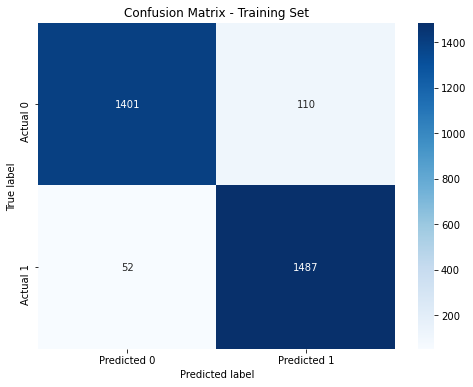

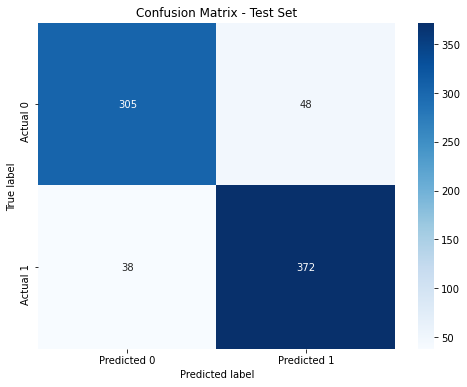

In [29]:
# Calculate confusion matrix for training set
cm_train = confusion_matrix(y_train, y_preds_lr)

# Plot confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Calculate confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_preds_lr)

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [30]:
print(classification_report(y_train, y_preds_lr))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1511
           1       0.93      0.97      0.95      1539

    accuracy                           0.95      3050
   macro avg       0.95      0.95      0.95      3050
weighted avg       0.95      0.95      0.95      3050



In [31]:
print(f'LogReg Train Accuracy: {accuracy_score(y_train, y_preds_lr):.1%}')

LogReg Train Accuracy: 94.7%


In [32]:
print(classification_report(y_test,y_test_preds_lr))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       353
           1       0.89      0.91      0.90       410

    accuracy                           0.89       763
   macro avg       0.89      0.89      0.89       763
weighted avg       0.89      0.89      0.89       763



In [33]:
print(f'LogReg Test Accuracy: {accuracy_score(y_test,y_test_preds_lr):.1%}')

LogReg Test Accuracy: 88.7%


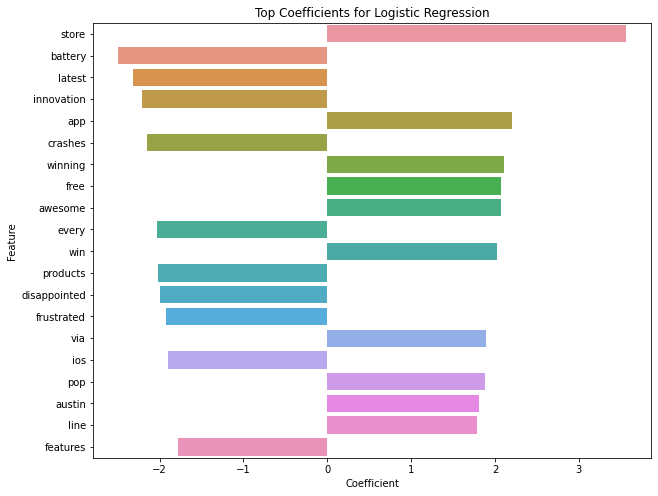

In [34]:
# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get the coefficients and their corresponding feature names
coef = logreg.coef_[0]
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})

# Sort the coefficients by absolute value
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Plot the top coefficients
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(20))
plt.title('Top Coefficients for Logistic Regression')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()

### Logistic Regression Result Summary 
The Logistic Regression model exhibits strong performance on both training and testing data, achieving high precision, recall, and F1-score. Although there's a slight decrease in performance on the testing data compared to the training data, it's not significant. There also doesnt appear to be too much overfitting and shows to perform reasonably well on unseen data. 

### Multinomial Naive Bayes

In [35]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [36]:
y_preds_mnb = mnb.predict(X_train_tfidf)
y_preds_test_mnb = mnb.predict(X_test_tfidf)

In [37]:
print(classification_report(y_train, y_preds_mnb))

              precision    recall  f1-score   support

           0       0.97      0.88      0.93      1511
           1       0.90      0.97      0.93      1539

    accuracy                           0.93      3050
   macro avg       0.93      0.93      0.93      3050
weighted avg       0.93      0.93      0.93      3050



In [38]:
print(f'MultinomialNB Train Accuracy: {accuracy_score(y_train, y_preds_mnb):.1%}')

MultinomialNB Train Accuracy: 93.0%


In [39]:
print(classification_report(y_test, y_preds_test_mnb))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       353
           1       0.87      0.92      0.89       410

    accuracy                           0.88       763
   macro avg       0.89      0.88      0.88       763
weighted avg       0.88      0.88      0.88       763



In [40]:
print(f'MultinomialNB Test Accuracy: {accuracy_score(y_test, y_preds_test_mnb):.1%}')

MultinomialNB Test Accuracy: 88.3%


### Multiomial Naive Bayes Result Summary 
The Multinomial Naive Bayes model demonstrates strong performance on both training and testing data, with high precision, recall, and F1-score. While there is a slight drop in performance on the testing data compared to the training data, it is not dramatic, indicating good generalization. The model is also achieving decent accuracy at 81.7% on the test data. 

### Cross Validation for Logistic Regression and MNB

In [41]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for Logistic Regression
logreg_cv_precision = cross_val_score(logreg, X_train_tfidf, y_train, cv=skf, scoring='precision')

# Cross-validation for Multinomial Naive Bayes
mnb_cv_precision = cross_val_score(mnb, X_train_tfidf, y_train, cv=skf, scoring='precision')

# Print results
print("Logistic Regression CV Precision: %0.3f (+/- %0.3f)" % (logreg_cv_precision.mean(), logreg_cv_precision.std() * 2))
print("Multinomial Naive Bayes CV Precision: %0.3f (+/- %0.3f)" % (mnb_cv_precision.mean(), mnb_cv_precision.std() * 2))

Logistic Regression CV Precision: 0.878 (+/- 0.050)
Multinomial Naive Bayes CV Precision: 0.858 (+/- 0.050)


### Support Vector Machines

In [42]:
svc = SVC(random_state=42)
svc.fit(X_train_tfidf, y_train)

SVC(random_state=42)

In [43]:
y_preds_svc = svc.predict(X_train_tfidf)
y_preds_test_svc = svc.predict(X_test_tfidf)

In [44]:
print(classification_report(y_train, y_preds_svc))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1511
           1       0.98      1.00      0.99      1539

    accuracy                           0.99      3050
   macro avg       0.99      0.99      0.99      3050
weighted avg       0.99      0.99      0.99      3050



In [45]:
print(classification_report(y_test, y_preds_test_svc))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       353
           1       0.89      0.92      0.91       410

    accuracy                           0.90       763
   macro avg       0.90      0.90      0.90       763
weighted avg       0.90      0.90      0.90       763



In [46]:
params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
          'degree':[2,3,4],
          'shrinking':[True,False],
         }

In [47]:
svc_grid = GridSearchCV(svc, param_grid=params, cv=5)

In [48]:
svc_grid.fit(X_train_tfidf, y_train)

57.36546349525452 seconds


In [49]:
print(svc_grid.best_estimator_)
print(svc_grid.best_params_)

SVC(degree=2, kernel='poly', random_state=42)
{'degree': 2, 'kernel': 'poly', 'shrinking': True}


In [50]:
svc_tuned = SVC(degree=2, kernel='poly', shrinking=True, random_state=42)
svc_tuned.fit(X_train_tfidf, y_train)

SVC(degree=2, kernel='poly', random_state=42)

In [51]:
y_preds_svc = svc_tuned.predict(X_train_tfidf)
y_preds_test_svc = svc_tuned.predict(X_test_tfidf)

In [52]:
print(classification_report(y_train, y_preds_svc))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1511
           1       0.99      1.00      0.99      1539

    accuracy                           0.99      3050
   macro avg       0.99      0.99      0.99      3050
weighted avg       0.99      0.99      0.99      3050



In [53]:
print(f'SVM Train Accuracy: {accuracy_score(y_train, y_preds_svc):.1%}')

SVM Train Accuracy: 99.4%


In [54]:
print(classification_report(y_test, y_preds_test_svc))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       353
           1       0.89      0.91      0.90       410

    accuracy                           0.89       763
   macro avg       0.89      0.89      0.89       763
weighted avg       0.89      0.89      0.89       763



In [55]:
print(f'SVM Test Accuracy: {accuracy_score(y_test, y_preds_test_svc):.1%}')

SVM Test Accuracy: 89.4%


### Support Vector Machines Result Summary 
The SVM model demonstrates excellent performance on both training and testing data, achieving high precision, recall, and F1-score for both spam and non-spam classes. On the training data, the model achieves near-perfect precision, recall, and F1-score for both classes, indicating an almost perfect fit to the training data. However, on the testing data, while the precision and recall remain relatively high, there's a noticeable decrease in performance compared to the training data, suggesting overfitting. The accuracy is indicative of overfitting, with 99.4% on the training data and 82.9% on the testing data. Hyperparameter tuning using GridSearchCV results in slightly improved performance on the testing data, but the overfitting issue persists.

### Random Forest

In [56]:
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [57]:
y_preds_rf = rf.predict(X_train_tfidf)
y_preds_test_rf = rf.predict(X_test_tfidf)

In [58]:
print(classification_report(y_train, y_preds_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1511
           1       1.00      1.00      1.00      1539

    accuracy                           1.00      3050
   macro avg       1.00      1.00      1.00      3050
weighted avg       1.00      1.00      1.00      3050



In [59]:
print(classification_report(y_test, y_preds_test_rf))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       353
           1       0.88      0.93      0.90       410

    accuracy                           0.89       763
   macro avg       0.90      0.89      0.89       763
weighted avg       0.90      0.89      0.89       763



In [60]:
rf_params = {'n_estimators':[10, 50, 100],
             'criterion':['gini','entropy','log_loss'],
             'max_depth':[5,10,20]
            }

In [61]:
rf_grid = GridSearchCV(rf, param_grid=rf_params, cv=5)

In [62]:
rf_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10, 20],
                         'n_estimators': [10, 50, 100]})

In [63]:
print(rf_grid.best_estimator_)
print(rf_grid.best_params_)

RandomForestClassifier(max_depth=20)
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}


In [70]:
rf2 = RandomForestClassifier(criterion='gini', max_depth=20, n_estimators=100, random_state=42)
rf2.fit(X_train_tfidf, y_train)

RandomForestClassifier(max_depth=20, random_state=42)

In [71]:
y_preds_rf2 = rf2.predict(X_train_tfidf)
y_preds_test_rf2 = rf2.predict(X_test_tfidf)

In [72]:
print(classification_report(y_train, y_preds_rf2))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1511
           1       0.92      0.84      0.88      1539

    accuracy                           0.88      3050
   macro avg       0.89      0.88      0.88      3050
weighted avg       0.89      0.88      0.88      3050



In [73]:
print(f'Random Forest Train Accuracy: {accuracy_score(y_train, y_preds_rf2):.1%}')

Random Forest Train Accuracy: 88.3%


In [74]:
print(classification_report(y_test, y_preds_test_rf2))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       353
           1       0.88      0.80      0.84       410

    accuracy                           0.83       763
   macro avg       0.83      0.84      0.83       763
weighted avg       0.84      0.83      0.83       763



In [75]:
print(f'Random Forest Test Accuracy: {accuracy_score(y_test, y_preds_test_rf2):.1%}')

Random Forest Test Accuracy: 83.2%


### Random Forest Model Result Summary 
The initial Random Forest Model was overfitting the training data, hyperparameter tuning was done using GridSearchCV to help find better paraments. The second Random Forest Model had had better results and resulted in a model that was less prone to overfitting. There is still some overfitting observed as the performance on the test data is slightly lower than the training data but overall is performing well. 

## Interpreted results

After conducting an analysis of various machine learning models for spam classification, we found that Logistic Regression outperformed the other models in terms of generalization and performance on both training and testing data.

The initial Random Forest Model suffered from overfitting, but after hyperparameter tuning, the second model showed improvement, although some overfitting was still observed. SVM demonstrated excellent performance on the training data but exhibited signs of overfitting on the testing data. Multinomial Naive Bayes also performed well with good generalization, achieving high precision, recall, and F1-score on both training and testing data.

However, Logistic Regression stood out as the most balanced model, with strong performance on both training and testing data, minimal overfitting, and good generalization. While slight decreases in performance were observed on the testing data compared to the training data for all models, Logistic Regression maintained high precision, recall, and F1-score, indicating its reliability classifying sentiment. Therefore, we conclude that Logistic Regression is the most suitable model for sentiment analysis in this scenario.

# Conclusion
Overwhelmingly, the sentiment towards Apple and Apple products at the SXSW conference was positive. In particular, iPad sentiment was very high - 86% of the time the sentiment was positive, as people were excited about the release of the iPad 2.

In-person engagement is key. People were thrilled about the temporary pop-up store that Apple created in downtown Austin. This gave consumers who otherwise might have been on the fence an opportunity to test the products for themselves while exploring downtown Austin. Translating that into the present-day, it’s recommended that Apple continues to find innovative retail pathways to create excitement around their products.

Form and function are still the keys to making successful products. Conference attendees had negative remarks about the short battery life of apple items. The design of products is key to creating a positive user experience, and it is recommended that Apple continues to innovate their designs to maximize usability.

Positive sentiment often leads to direct sales. In the earnings report 2 weeks after the SXSW conference, Apple reported a 2% increase in iPhones sales and a 65% increase in iPad sales compared to the year prior.